# WEAC Generalized Backend API Documentation

This notebook provides comprehensive documentation on how to use the **generalized backend** in WEAC (Weak Interface Avalanche Calculations). The generalized backend is designed for advanced simulations with stratified snow covers and complex scenario configurations.

---

## Overview

The generalized backend (`backend="generalized"`) extends WEAC's capabilities by:

- Supporting **arbitrary sample orientations** (rotation around different axes)
- Handling **complex slab profiles** with multiple layers
- Enabling **energy release rate (ERR) calculations** for different crack configurations
- Supporting both **skier-triggered** and **propagation saw test (PST)** scenarios
- Providing **analytical stress and displacement** field access

---

## 1. Installation and Imports

Ensure WEAC is installed with all dependencies:

In [1]:
# Auto reload for interactive development
%load_ext autoreload
%autoreload all

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from weac.components import (
    Layer,
    Config,
    ScenarioConfig,
    ModelInput,
    WeakLayer,
    Segment,
)
from weac.core.system_model import SystemModel
from weac.analysis.analyzer import Analyzer
from weac.analysis.plotter import Plotter
from weac.utils.misc import load_dummy_profile

---
## 2. Core Components Configuration

### 2.1 Defining Slab Layers

The `Layer` component defines individual snow layers in the slab:

In [4]:
# Method 1: Load a predefined dummy profile
dummy_layers = load_dummy_profile("a")  # Options: "a", "b", "c", etc.

# Method 2: Define custom layer profile
custom_layers = [
    Layer(rho=170, h=100),  # Layer 1: density 170 kg/m³, height 100 mm
    Layer(rho=190, h=40),  # Layer 2
    Layer(rho=230, h=130),  # Layer 3
    Layer(rho=250, h=20),  # Layer 4
    Layer(rho=210, h=70),  # Layer 5
    Layer(rho=380, h=20),  # Layer 6
    Layer(rho=280, h=100),  # Layer 7 (top layer above weak layer)
]

# Single homogeneous layer (simplified case)
homogeneous_layers = [
    Layer(rho=240, h=200)  # Density 240 kg/m³, height 200 mm
]

### 2.2 Defining the Weak Layer

The `WeakLayer` component defines the failure interface:

In [5]:
# Basic weak layer configuration
weak_layer = WeakLayer(
    rho=120,  # Density in kg/m³
    h=20,  # Height/thickness in mm
)

# Weak layer with specified elastic modulus
weak_layer_custom = WeakLayer(
    rho=120,
    h=20,
    E=0.8462740448617735,  # Custom elastic modulus
)

### 2.3 Defining Segments

The `Segment` component represents sections along the weak layer with different properties:

In [6]:
# Example: Skier scenario - loads applied at segments
skier_segments = [
    Segment(length=5000, has_foundation=True, m=0),  # Left foundation, no load
    Segment(length=500, has_foundation=False, m=80),  # Skier load: 80 kg
    Segment(
        length=500, has_foundation=False, m=0
    ),  # No load between skier and foundation
    Segment(length=5000, has_foundation=True, m=0),  # Right foundation, no load
]

# Example: PST (Propagation Saw Test) scenario - cut and loaded region
pst_segments = [
    Segment(
        length=1000, has_foundation=True, is_loaded=True, m=0
    ),  # Uncut, loaded region
    Segment(
        length=200, has_foundation=False, is_loaded=True, m=0
    ),  # Cut region (being propagated)
]

# Segment parameters:
# - length: segment length in mm
# - has_foundation: True if supported from below, False if free-standing
# - is_loaded: True if under surface load (PST scenarios)
# - m: point load magnitude in kg (skier scenarios)

### 2.4 Defining Scenario Configuration

The `ScenarioConfig` specifies the loading and geometric conditions:

In [7]:
# Skier scenario with inclination and rotation
skier_config = ScenarioConfig(
    system_type="skier",  # Type: "skier" or "pst+" / "pst-"
    phi=30,  # Slope inclination in degrees
    theta=20,  # Rotation around axis in degrees
    b=250,  # Out-of-plane width in mm
    surface_load=0,  # Additional surface load in kg/m²
)

# PST scenario (cut from right side)
pst_config_right = ScenarioConfig(
    system_type="pst-",  # pst-: cut from right; pst+: cut from left
    phi=-30,  # Slope inclination (negative for downslope)
    theta=0,  # No rotation
    b=200,  # Out-of-plane width in mm
    surface_load=0,
    cut_length=300,  # Length of the cut in mm
)

# PST scenario with rotation
pst_config_rotated = ScenarioConfig(
    system_type="pst-",
    phi=30,
    theta=20,  # 20° rotation
    b=250,  # Out-of-plane width in mm
    surface_load=0,
    cut_length=300,
)

### 2.5 Backend Configuration

The `Config` component specifies which backend to use and related options:

In [8]:
# Generalized backend configuration

# Generalized backend without touchdown
config_generalized = Config(
    backend="generalized",
    touchdown=False,
)

---
## 3. Creating and Running a System Model

### 3.1 Model Input Assembly

Combine all components into a `ModelInput` object:

In [9]:
# Assemble the model input
model_input = ModelInput(
    scenario_config=skier_config,  # Scenario configuration
    layers=custom_layers,  # Slab layers
    weak_layer=weak_layer,  # Weak layer interface
    segments=skier_segments,  # Segment configuration
)

### 3.2 Initialize the System Model

Create a `SystemModel` using the generalized backend:

In [10]:
# Create the system model with generalized backend
system = SystemModel(
    model_input=model_input,
    config=config_generalized,
)

# The system model now contains:
# - system.slab: Slab information and properties
# - system.weak_layer: Weak layer properties
# - system.scenario: Scenario configuration
# - system.eigensystem: Eigenvalue problem solution
# - system.slab_touchdown: Touchdown analysis (if enabled)

---
## 4. Analyzing Results with the Analyzer

The `Analyzer` class provides methods to extract and process results from the system model:

In [11]:
# Create an analyzer
analyzer = Analyzer(system)

# Rasterize the solution for plotting
# Returns: (x_slab, z_slab, x_weaklayer)
x_slab, z_slab, x_weaklayer = analyzer.rasterize_solution(mode="cracked")

# The rasterized data contains spatial point coordinates and field values
# for visualization and analysis

### 4.1 Energy Release Rate Calculations

Calculate energy release rates for fracture mechanics analysis:

In [12]:
# Differential Energy Release Rate (ERR)
# Represents the change in ERR at the current crack length
Gdif = analyzer.differential_ERR()
# Returns array: [G_total, G_I, G_II, G_III] in J/m²

### 4.2 Accessing Model Properties

Query system properties for material and geometric information:

In [13]:
# Slab properties
slab_thickness = system.slab.H  # Total slab height
slab_width = system.slab.b  # Slab width
slab_mass = system.slab.qw  # Slab weight per unit area
slab_cog = system.slab.z_cog  # Center of gravity height

# Weak layer properties
weak_layer_friction = system.weak_layer.f  # Friction coefficient
weak_layer_nu = system.weak_layer.nu  # Poisson's ratio
weak_layer_kn = system.weak_layer.kn  # Normal stiffness

# Eigensystem properties (stiffness matrices)
A11 = system.eigensystem.A11  # Bending stiffness
B11 = system.eigensystem.B11  # Coupling stiffness
D11 = system.eigensystem.D11  # Extensional stiffness
kA55 = system.eigensystem.kA55  # Shear stiffness (upper slab)
kB55 = system.eigensystem.kB55  # Shear stiffness (middle)
kD55 = system.eigensystem.kD55  # Shear stiffness (lower slab)

---
## 5. Updating Scenarios Dynamically

Modify scenario parameters and re-analyze without recreating the system:

In [14]:
# Update scenario configuration (e.g., change inclination)
new_config = system.scenario.scenario_config
new_config.phi = 40  # Change inclination to 40°
new_config.theta = 15  # Change rotation to 15°

system.update_scenario(scenario_config=new_config)

# Re-create analyzer with updated system
analyzer = Analyzer(system)

# Calculate new ERR values with updated scenario
new_Gdif = analyzer.differential_ERR()

### 5.1 Iterative Crack Length Analysis

Example: Calculate ERR as a function of crack length for PST scenarios:

In [15]:
# Number of crack length increments
n_increments = 50

# Array to store results
da = np.linspace(1e-6, 250, num=n_increments)  # Crack length in mm
Gdif_array = np.zeros([4, n_increments])  # [G_total, G_I, G_II, G_III]

# Calculate ERR for each crack length
for i in range(n_increments):
    # Calculate uncut segment length
    L = 4000 - da[i]

    # Update segments for current crack length
    pst_segments_updated = [
        Segment(length=L, has_foundation=True, is_loaded=True, m=0),
        Segment(length=da[i], has_foundation=False, is_loaded=True, m=0),
    ]

    # Update the system with new segments
    system.update_scenario(segments=pst_segments_updated)

    # Re-create analyzer and calculate ERR
    analyzer = Analyzer(system)
    Gdif_array[:, i] = analyzer.differential_ERR()

# Now Gdif_array contains ERR values for each crack length

---
## 6. Visualization with the Plotter

The `Plotter` class provides visualization methods:

### 6.1 Basic Visualizations

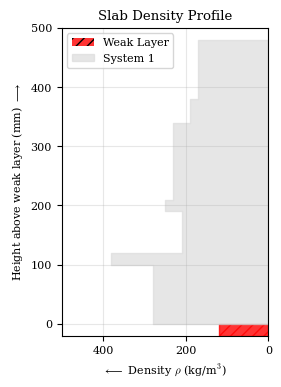

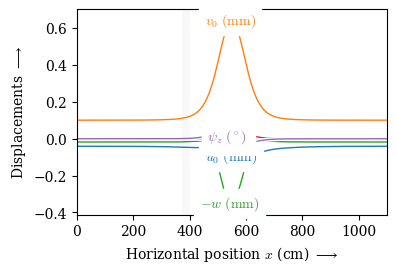

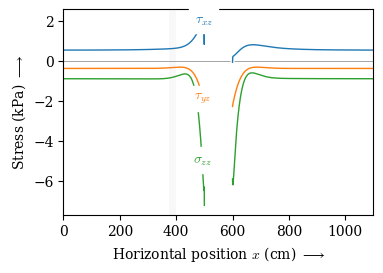

In [16]:
# Create plotter instance
plotter = Plotter()

# Plot slab profile
fig = plotter.plot_slab_profile(
    weak_layers=system.weak_layer,
    slabs=system.slab,
)

# Plot displacements
fig = plotter.plot_displacements(analyzer, x=x_slab, z=z_slab)

# Plot weak-layer stresses
fig = plotter.plot_stresses(analyzer, x=x_weaklayer, z=z_slab)

### 6.2 Energy Release Rate Visualization

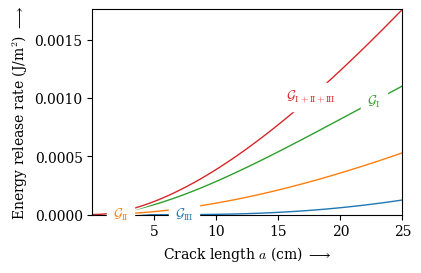

In [17]:
# Plot differential ERR vs crack length
fig = plotter.plot_ERR_modes(
    analyzer,
    da,  # Crack length array
    Gdif_array,  # ERR data array
    kind="dif",  # Type: "dif" (differential) or "inc" (incremental)
)

---
## 7. Complete Workflow Example

Here is a complete example integrating all components:

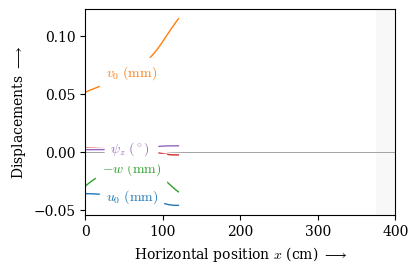

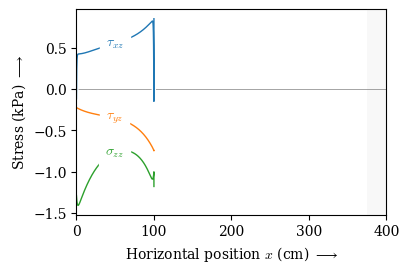

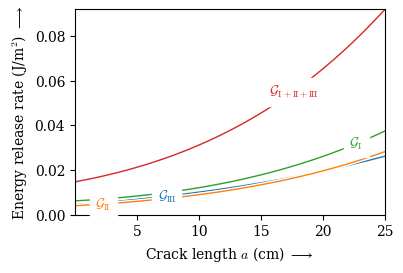

In [18]:
# ===== SETUP =====
layers = load_dummy_profile("a")
weak_layer = WeakLayer(rho=120, h=20)

# ===== CONFIGURATION =====
scenario_config = ScenarioConfig(
    system_type="pst-",
    phi=30,
    theta=20,
    b=290,
    cut_length=300,
)

segments = [
    Segment(length=1000, has_foundation=True, is_loaded=True, m=0),
    Segment(length=200, has_foundation=False, is_loaded=True, m=0),
]

config = Config(backend="generalized", touchdown=False)

# ===== CREATE MODEL =====
model_input = ModelInput(
    scenario_config=scenario_config,
    layers=layers,
    weak_layer=weak_layer,
    segments=segments,
)

system = SystemModel(
    model_input=model_input,
    config=config,
)

# ===== ANALYZE =====
analyzer = Analyzer(system)
x_slab, z_slab, x_weaklayer = analyzer.rasterize_solution(mode="cracked")

# ===== CALCULATE ERR =====
n = 50
da = np.linspace(1e-6, 250, num=n)
Gdif = np.zeros([4, n])

for i in range(n):
    L = 4000 - da[i]
    system.update_scenario(
        segments=[
            Segment(length=L, has_foundation=True, is_loaded=True, m=0),
            Segment(length=da[i], has_foundation=False, is_loaded=True, m=0),
        ]
    )
    analyzer = Analyzer(system)
    Gdif[:, i] = analyzer.differential_ERR()

# ===== VISUALIZE =====
plotter = Plotter()
plotter.plot_displacements(analyzer, x=x_slab, z=z_slab)
plotter.plot_stresses(analyzer, x=x_weaklayer, z=z_slab)
plotter.plot_ERR_modes(analyzer, da, Gdif, kind="dif")

---
## 8. Key API Reference

### Configuration Components

| Component | Purpose | Key Parameters |
|-----------|---------|----------------|
| `Layer` | Define snow layer | `rho` (density), `h` (height) |
| `WeakLayer` | Define failure interface | `rho`, `h`, `E` (optional) |
| `Segment` | Define weak layer sections | `length`, `has_foundation`, `is_loaded`, `m` |
| `ScenarioConfig` | Set loading conditions | `system_type`, `phi`, `theta`, `surface_load`, `cut_length` |
| `Config` | Backend configuration | `backend`, `touchdown` |
| `ModelInput` | Combine all components | All of above |

### System Model

| Method/Property | Description |
|-----------------|-------------|
| `SystemModel()` | Create model with components and config |
| `.slab` | Access slab properties |
| `.weak_layer` | Access weak layer properties |
| `.scenario` | Access scenario information |
| `.eigensystem` | Access stiffness matrices and eigenvalues |
| `.update_scenario()` | Dynamically update configuration |

### Analyzer

| Method | Returns | Units |
|--------|---------|-------|
| `.rasterize_solution()` | Spatial coordinates and field values | mm, - |
| `.differential_ERR()` | `[G_total, G_I, G_II, G_III]` | J/m² |
| `.incremental_ERR()` | `[G_total, G_I, G_II, 0]` | J/m² |

### Plotter 

| Method | Parameters | Output |
|--------|------------|--------|
| `.plot_slab_profile()` | `weak_layers`, `slabs` | Figure |
| `.plot_displacements()` | `analyzer`, `x`, `z` | Figure |
| `.plot_stresses()` | `analyzer`, `x`, `z` | Figure |
| `.plot_ERR_modes()` | `analyzer`, `da`, `ERR_array`, `kind` | Figure |

---
## Summary

The generalized backend provides a comprehensive framework for analyzing snow slab stability. The workflow is straightforward:

1. **Define components**: Layers, weak layer, segments, scenario
2. **Configure backend**: Set `backend="generalized"`
3. **Create system**: Instantiate `SystemModel`
4. **Analyze**: Use `Analyzer` for ERR and field calculations
5. **Visualize**: Use `Plotter` for output rendering

For questions or detailed model information, refer to the companion research papers and WEAC documentation.